In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import seaborn as sns

In [13]:
BASE_PATH = "/kaggle/input/gtsrb-german-traffic-sign"
TRAIN_CSV = f"{BASE_PATH}/Train.csv"
TEST_CSV = f"{BASE_PATH}/Test.csv"

# Load CSVs
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Convert ClassId to string for categorical mode
train_df["ClassId"] = train_df["ClassId"].astype(str)
test_df["ClassId"] = test_df["ClassId"].astype(str)

print("Training samples:", len(train_df))
print("Testing samples:", len(test_df))
print("Number of classes:", train_df['ClassId'].nunique())


Training samples: 39209
Testing samples: 12630
Number of classes: 43


In [18]:
IMG_SIZE = (32,32)
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_PATH,
    x_col="Path",
    y_col="ClassId",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

# Validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_PATH,
    x_col="Path",
    y_col="ClassId",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 31368 validated image filenames belonging to 43 classes.
Found 7841 validated image filenames belonging to 43 classes.


In [19]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_df['ClassId'].nunique(), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,979 (1.22 MB)

 Trainable params: 319,979 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1961/1961 ━━━━━━━━━━━━━━━━━━━━ 103s 50ms/step - accuracy: 0.2857 - loss: 2.5846 - val_accuracy: 0.0232 - val_loss: 16.5055
Epoch 2/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.6663 - loss: 0.9879 - val_accuracy: 0.0935 - val_loss: 24.1341
Epoch 3/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 71s 36ms/step - accuracy: 0.7699 - loss: 0.6800 - val_accuracy: 0.1169 - val_loss: 23.9726
Epoch 4/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.8187 - loss: 0.5354 - val_accuracy: 0.1384 - val_loss: 27.9772
Epoch 5/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.8593 - loss: 0.4236 - val_accuracy: 0.1469 - val_loss: 31.7270
Epoch 6/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.8803 - loss: 0.3613 - val_accuracy: 0.1523 - val_loss: 29.7229
Epoch 7/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 79s 40ms/step - accuracy: 0.8913 - loss: 0.3275 - val_accuracy: 0.1426 - val_loss: 34.4756
Epoch 8/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.9108 - lo

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=BASE_PATH,
    x_col="Path",
    y_col="ClassId",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 12630 validated image filenames belonging to 43 classes.


In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

# Predictions
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.7881 - loss: 9.8374
Test Accuracy: 0.7860649228096008
790/790 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step


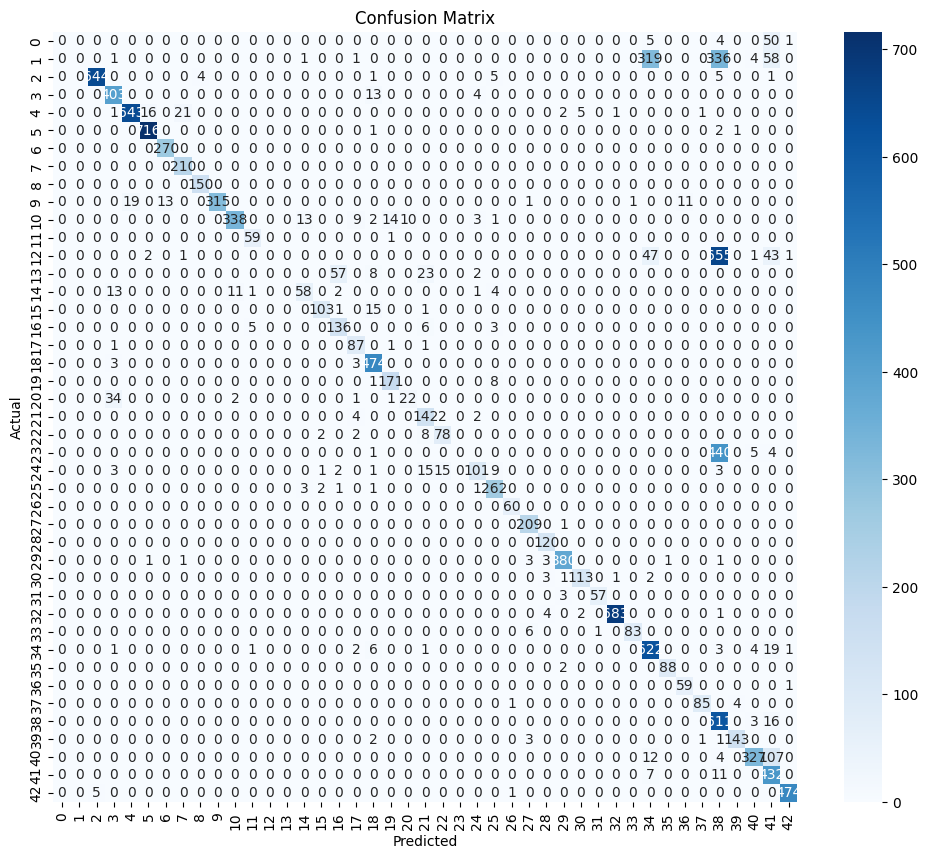

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00       720
           2       0.99      0.98      0.98       660
           3       0.88      0.96      0.92       420
           4       0.97      0.93      0.95       690
           5       0.97      0.99      0.98       720
           6       0.95      1.00      0.98       270
           7       0.90      1.00      0.95       210
           8       0.97      1.00      0.99       150
           9       1.00      0.88      0.93       360
          10       0.96      0.87      0.91       390
          11       0.89      0.98      0.94        60
          12       0.00      0.00      0.00       750
          13       0.00      0.00      0.00        90
          14       0.77      0.64      0.70        90
          15       0.95      0.86      0.90       120
          16       0.68      0.91      0.78       150
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred))


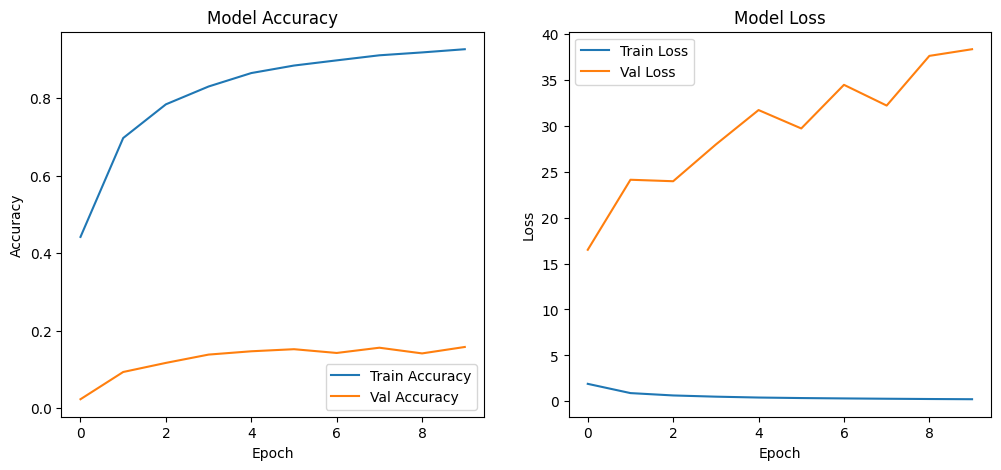

In [24]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [25]:
#bonus
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

IMG_SIZE = (64,64)
BATCH_SIZE = 16

# Use preprocess_input for MobileNet
mobilenet_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

mobilenet_train_gen = mobilenet_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_PATH,
    x_col="Path",
    y_col="ClassId",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

mobilenet_val_gen = mobilenet_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_PATH,
    x_col="Path",
    y_col="ClassId",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 31368 validated image filenames belonging to 43 classes.
Found 7841 validated image filenames belonging to 43 classes.


In [26]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_df['ClassId'].nunique(), activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()


/tmp/ipython-input-1486548802.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 32, 32, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 32, 32, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 16, 16, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 16, 16, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 16, 16, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 16, 16, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,365,611 (12.84 MB)

 Trainable params: 136,747 (534.17 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [27]:
history_mobilenet = mobilenet_model.fit(
    mobilenet_train_gen,
    epochs=10,
    validation_data=mobilenet_val_gen
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1961/1961 ━━━━━━━━━━━━━━━━━━━━ 69s 31ms/step - accuracy: 0.4694 - loss: 1.9395 - val_accuracy: 0.0649 - val_loss: 16.6506
Epoch 2/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 57s 29ms/step - accuracy: 0.7290 - loss: 0.8243 - val_accuracy: 0.0729 - val_loss: 22.7857
Epoch 3/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.7865 - loss: 0.6324 - val_accuracy: 0.0842 - val_loss: 24.7048
Epoch 4/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.8232 - loss: 0.5323 - val_accuracy: 0.0728 - val_loss: 28.9259
Epoch 5/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.8376 - loss: 0.4880 - val_accuracy: 0.0816 - val_loss: 35.2484
Epoch 6/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.8508 - loss: 0.4452 - val_accuracy: 0.0787 - val_loss: 35.2268
Epoch 7/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - accuracy: 0.8604 - loss: 0.4064 - val_accuracy: 0.0749 - val_loss: 41.5613
Epoch 8/10
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.8679 - los

Found 12630 validated image filenames belonging to 43 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


790/790 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step
MobileNet Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00       720
           2       0.72      0.82      0.77       660
           3       0.48      0.59      0.53       420
           4       0.92      0.94      0.93       690
           5       0.94      0.98      0.96       720
           6       0.98      0.91      0.94       270
           7       0.99      0.94      0.96       210
           8       0.80      0.82      0.81       150
           9       0.95      0.89      0.92       360
          10       0.64      0.60      0.62       390
          11       0.40      0.27      0.32        60
          12       0.00      0.00      0.00       750
          13       0.00      0.00      0.00        90
          14       0.57      0.30      0.39        90
          15       0.39      0.45      0.42       120
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


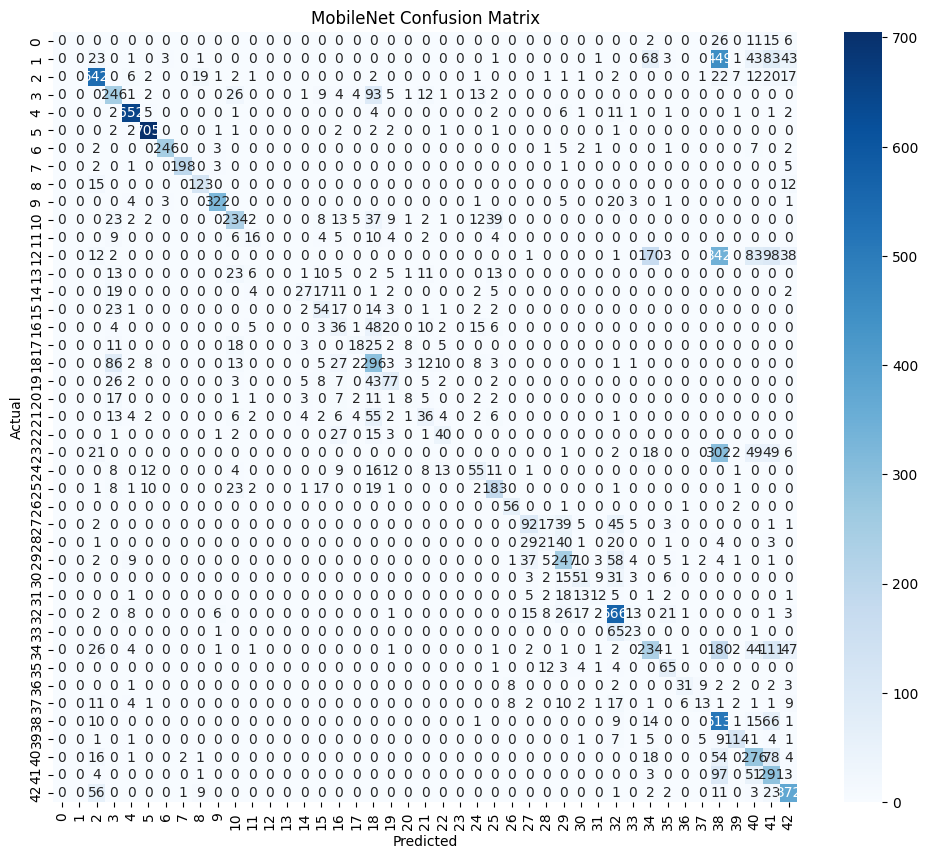

In [28]:
# Test generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=BASE_PATH,
    x_col="Path",
    y_col="ClassId",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Predictions
y_pred_mobilenet = np.argmax(mobilenet_model.predict(test_gen), axis=1)
y_true = test_gen.classes

print("MobileNet Classification Report:")
print(classification_report(y_true, y_pred_mobilenet))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_mobilenet)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MobileNet Confusion Matrix")
plt.show()

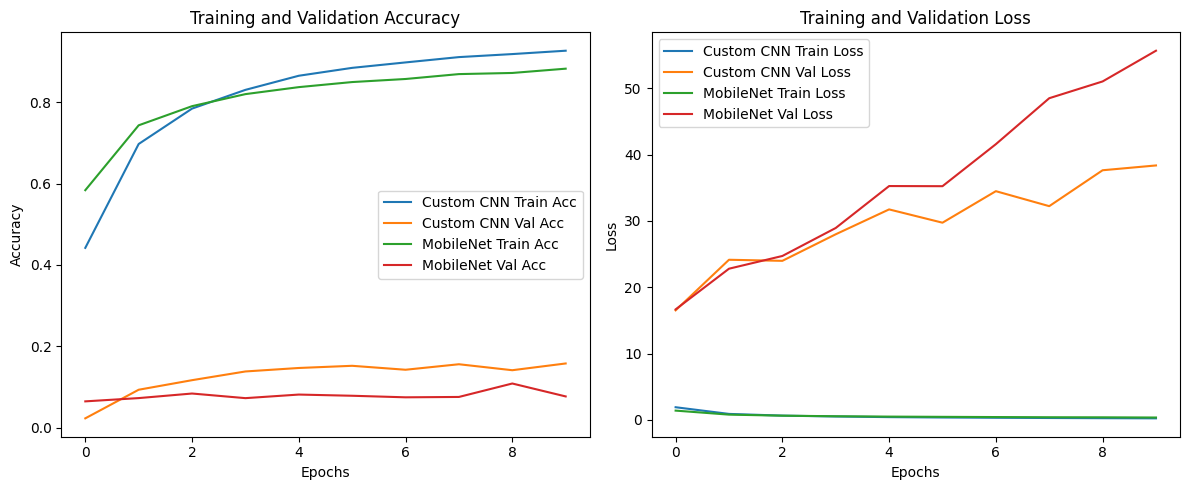

In [30]:

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Custom CNN Train Acc')
plt.plot(history.history['val_accuracy'], label='Custom CNN Val Acc')
plt.plot(history_mobilenet.history['accuracy'], label='MobileNet Train Acc')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNet Val Acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Custom CNN Train Loss')
plt.plot(history.history['val_loss'], label='Custom CNN Val Loss')
plt.plot(history_mobilenet.history['loss'], label='MobileNet Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNet Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
